# Exploratorio



----

<a id="2"></a> <br>
**0 -> LIBRERÍAS**

In [114]:
import pandas as pd
import numpy as np
import json
import requests
import time
from datetime import datetime
import math
import statistics

import matplotlib.pyplot as plt
import squarify
import seaborn as sns

import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

class display(object):
    """Representador HTML de múltiples objetos"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

### RESUMEN DE DATOS - Base de datos y parámetros musicales

>**df_top_world** -> 50 canciones más oidas del mundo en 2022<br>
>**df_top_spain** -> 100 canciones más oidas en España en 2022


>**df_additional_info_*** -> Track_ID, Release_Date, Track_Popularity, ISRC<br>
>**df_analysis_info_*** -> Track_ID, Duracion, Loudness_dB, Clave, Modo, Tempo_BPM, Compas, Danceability, Energy, Speechiness, Instrumentalness, Acousticness, Liveness, Valence<br>
>**df_track_by_artist_*** -> Track_ID, Track_Main_Artist, Track_Main_Artist_ID, Track_Featured_Artist, Track_Featured_Artist_ID<br>
>**df_artist_info_*** -> Artist_ID, Artist, Followers_Spotify, Genres_List, Artist_Popularity


Los recupero de sus CSV.

In [115]:
# PLAYLIST
df_top_world = pd.read_csv('../data/df_top_world.csv', sep=';')
df_top_spain = pd.read_csv('../data/df_top_spain.csv', sep=';')

# INFO SOBRE CANCIONES
df_additional_info_world = pd.read_csv('../data/df_additional_info_world.csv', sep=';')
df_additional_info_spain = pd.read_csv('../data/df_additional_info_spain.csv', sep=';')
df_analysis_info_world = pd.read_csv('../data/df_analysis_info_world.csv', sep=';')
df_analysis_info_spain = pd.read_csv('../data/df_analysis_info_spain.csv', sep=';')

# INFO SOBRE ARTISTAS
df_track_by_artist_world = pd.read_csv('../data/df_track_by_artist_world.csv', sep=';')
df_track_by_artist_spain = pd.read_csv('../data/df_track_by_artist_spain.csv', sep=';')
df_artist_info_world = pd.read_csv('../data/df_artist_info_world.csv', sep=';')
df_artist_info_spain = pd.read_csv('../data/df_artist_info_spain.csv', sep=';')

In [116]:
# TENGO QUE CONVERTIR LOS GÉNEROS A LISTA

import ast

def convertir_a_lista(genres_str):
  # Usa ast.literal_eval para evaluar la cadena de texto como una expresión literal de Python
  genres = ast.literal_eval(genres_str)

  # Devuelve la lista resultante
  return genres

# Aplica la función de conversión a cada fila de la columna 'Genres_List' del dataframe
df_artist_info_world['Genres_List'] = df_artist_info_world['Genres_List'].apply(convertir_a_lista)
df_artist_info_spain['Genres_List'] = df_artist_info_spain['Genres_List'].apply(convertir_a_lista)

Constantes que usaremos de forma auxiliar.

In [117]:
# PARA LIMPIAR Y UNIFICAR LOS GENEROS MUSICALES
DICT_GENRES = {
    # KEYWORD -> VALOR A ASIGNAR
    'edm': 'edm',
    'hip hop': 'hip-hop',
    'house': 'house',
    'indie': 'indie',
    'pop': 'pop',
    'r&b': 'r&b',
    'rap': 'hip-hop',
    'reggaeton': 'reggaeton',
    'rock': 'rock',
    'singer-songwriter': 'singer-songwriter',
    'urbano': 'urbano latino',
    'talent show': 'talent show',
}

#### GÉNEROS
Visualizamos la distribución de géneros musicales usando un treemap.

In [118]:
# ==== DATOS MUNDIALES # NOTA: LA COLUMNA Genres_List DEBE SALIR COMO LISTA.
list_genres = df_artist_info_world['Genres_List'] # LISTA DE LISTAS CON LOS GÉNEROS ASOCIADOS A CADA ARTISTA

# DECLARO LA LISTA VACÍA
genres_world = []

# ME QUEDO CON TODOS LOS ESTILOS INDEPENDIENTES DE LAS LISTAS
for i in list_genres:


    for genre in i:

        # DOY FORMATO Y AGRUPO LOS SIMILARES
        for key, value in DICT_GENRES.items():
            if key in genre:
                genre = value

        # SI TIENE MÁS DE 12 CARACTERES, METO SALTO DE LÍNEA
        if len(genre) > 12:
            genre = genre.replace(' ', '\n')

        genres_world.append(genre)

# CREO LA CUENTA PARA LOS TAMAÑOS
genre_count_world = {}

for genre in genres_world:
    if genre in genre_count_world:
        genre_count_world[genre] += 1
    else:
        genre_count_world[genre] = 1

# DEFINO LOS TAMAÑOS SEGUN EL METODO DE SQUARIFY
sizes_world = [genre_count_world[genre] for genre in genre_count_world]

# ==== DATOS ESPAÑA
df_artist_info_spain['Genres_List']
genres_spain = []

# ME QUEDO CON TODOS LOS ESTILOS INDEPENDIENTES DE LAS LISTAS
for i in df_artist_info_spain['Genres_List']:
    for genre in i:

        # DOY FORMATO Y AGRUPO LOS SIMILARES
        for key, value in DICT_GENRES.items():
            if key in genre:
                genre = value

        # SI TIENE MÁS DE 12 CARACTERES, METO SALTO DE LÍNEA
        if len(genre) > 12:
            genre = genre.replace(' ', '\n')

        genres_spain.append(genre)

# CREO LA CUENTA PARA LOS TAMAÑOS
genre_count_spain = {}

for genre in genres_spain:
    if genre in genre_count_spain:
        genre_count_spain[genre] += 1
    else:
        genre_count_spain[genre] = 1

# DEFINO LOS TAMAÑOS SEGUN EL METODO DE SQUARIFY
sizes_spain = [genre_count_spain[genre] for genre in genre_count_spain]

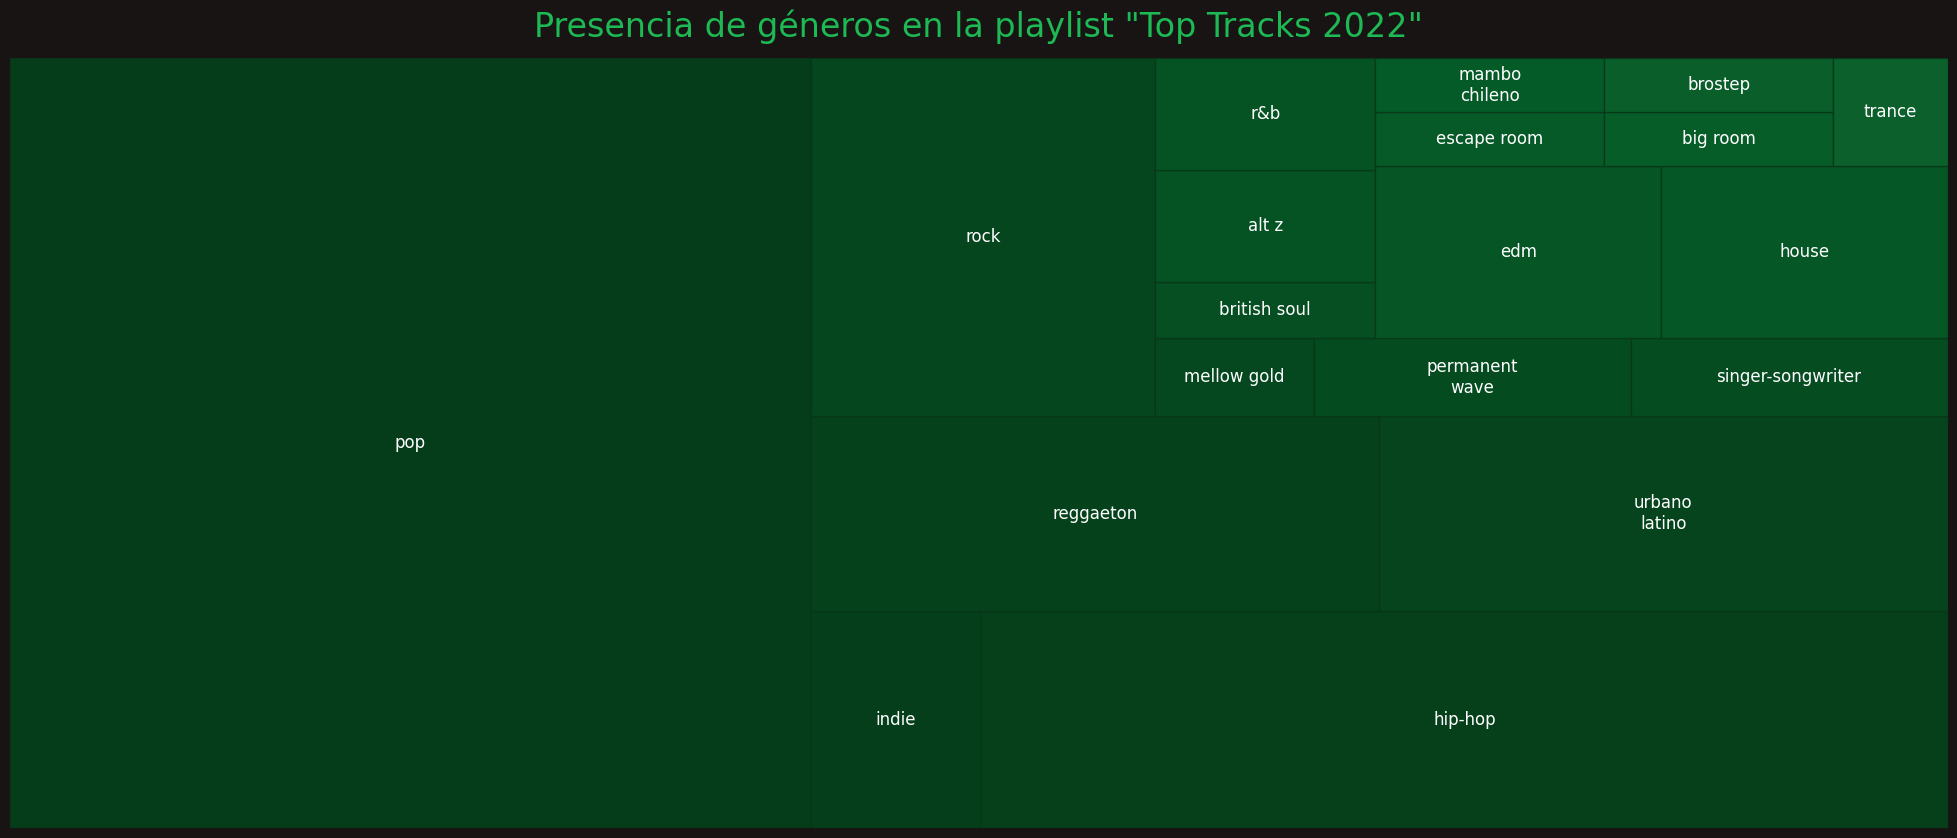

In [119]:
# PLOT MUNDIAL
fig = plt.figure(figsize=(25, 10))
fig.patch.set_facecolor('#191414') # FONDO DEL GRÁFICO
plt.axis("off")
squarify.plot(
    sizes=sizes_world, 
    label=genre_count_world.keys(), 
    color=sns.color_palette("Greens_r", len(genres_world)),
    ec = '#093618', # BORDES DE LOS CUADROS
    text_kwargs = {'fontsize': 12, 'color': 'white'},
    alpha = 0.8,
    )
plt.title('Presencia de géneros en la playlist "Top Tracks 2022"', fontsize=24, color = '#1DB954', pad=15)
plt.show()

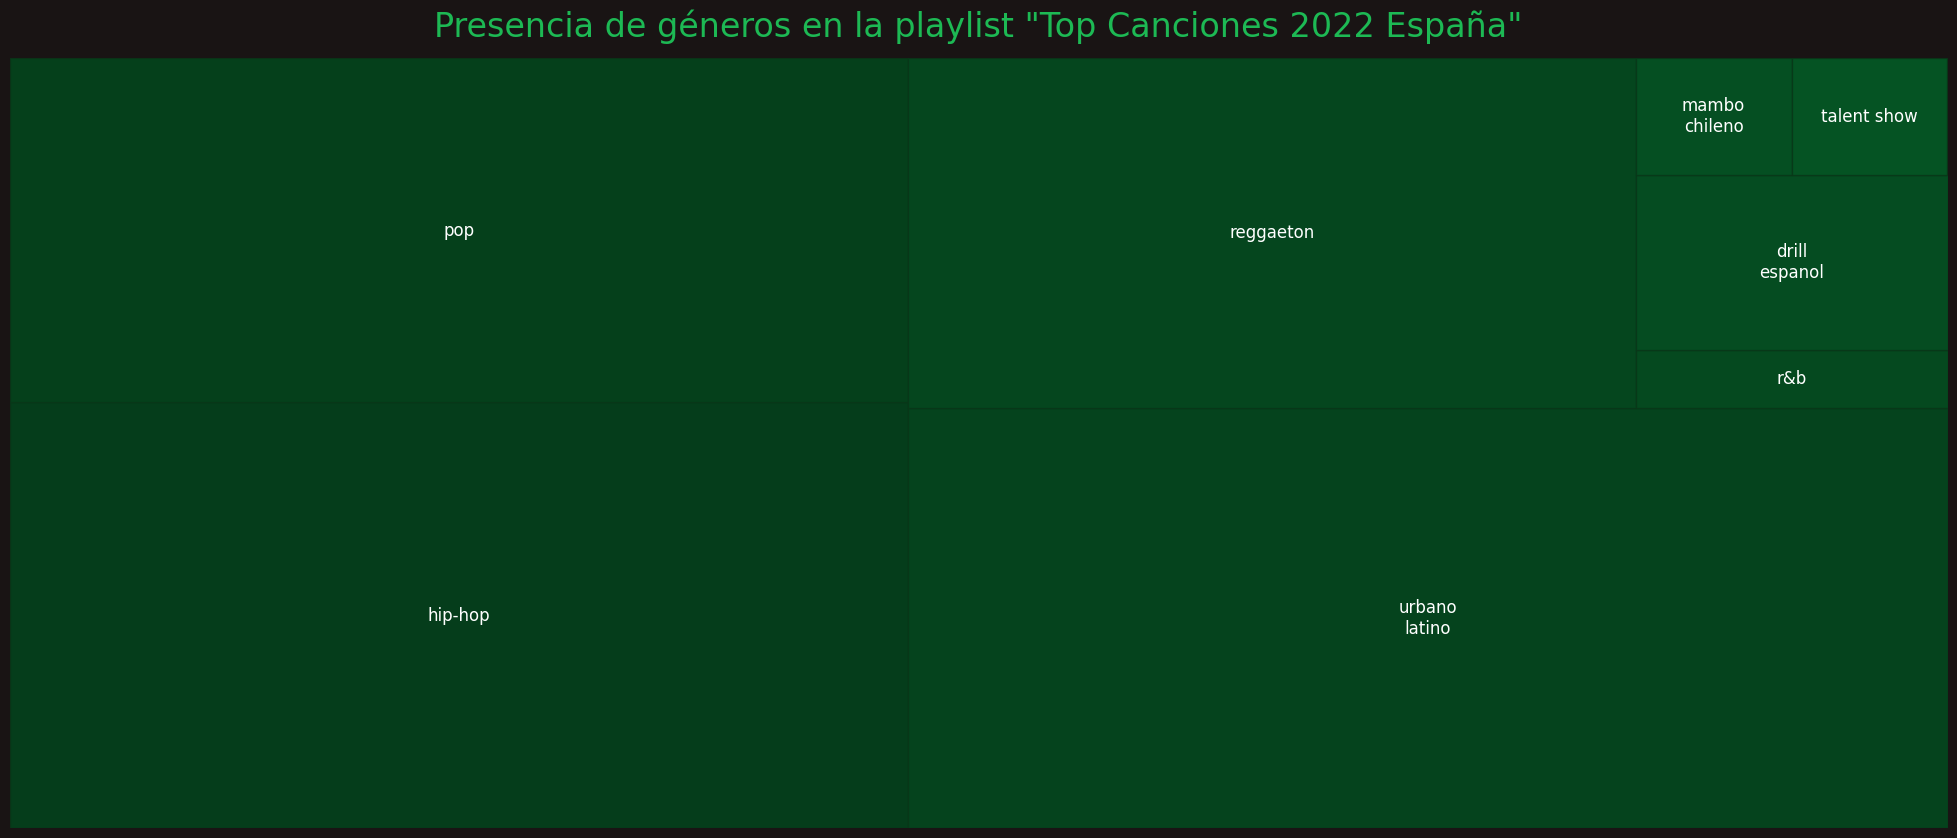

In [120]:
# PLOT ESPAÑA
fig = plt.figure(figsize=(25, 10))
fig.patch.set_facecolor('#191414') # FONDO DEL GRÁFICO
plt.axis("off")
squarify.plot(
    sizes=sizes_spain, 
    label=genre_count_spain.keys(), 
    color=sns.color_palette("Greens_r", len(genres_spain)),
    ec = '#093618', # BORDES DE LOS CUADROS
    text_kwargs = {'fontsize': 12, 'color': 'white'},
    alpha = 0.8,
    )
plt.title('Presencia de géneros en la playlist "Top Canciones 2022 España"', fontsize=24, color = '#1DB954', pad=15)
plt.show()

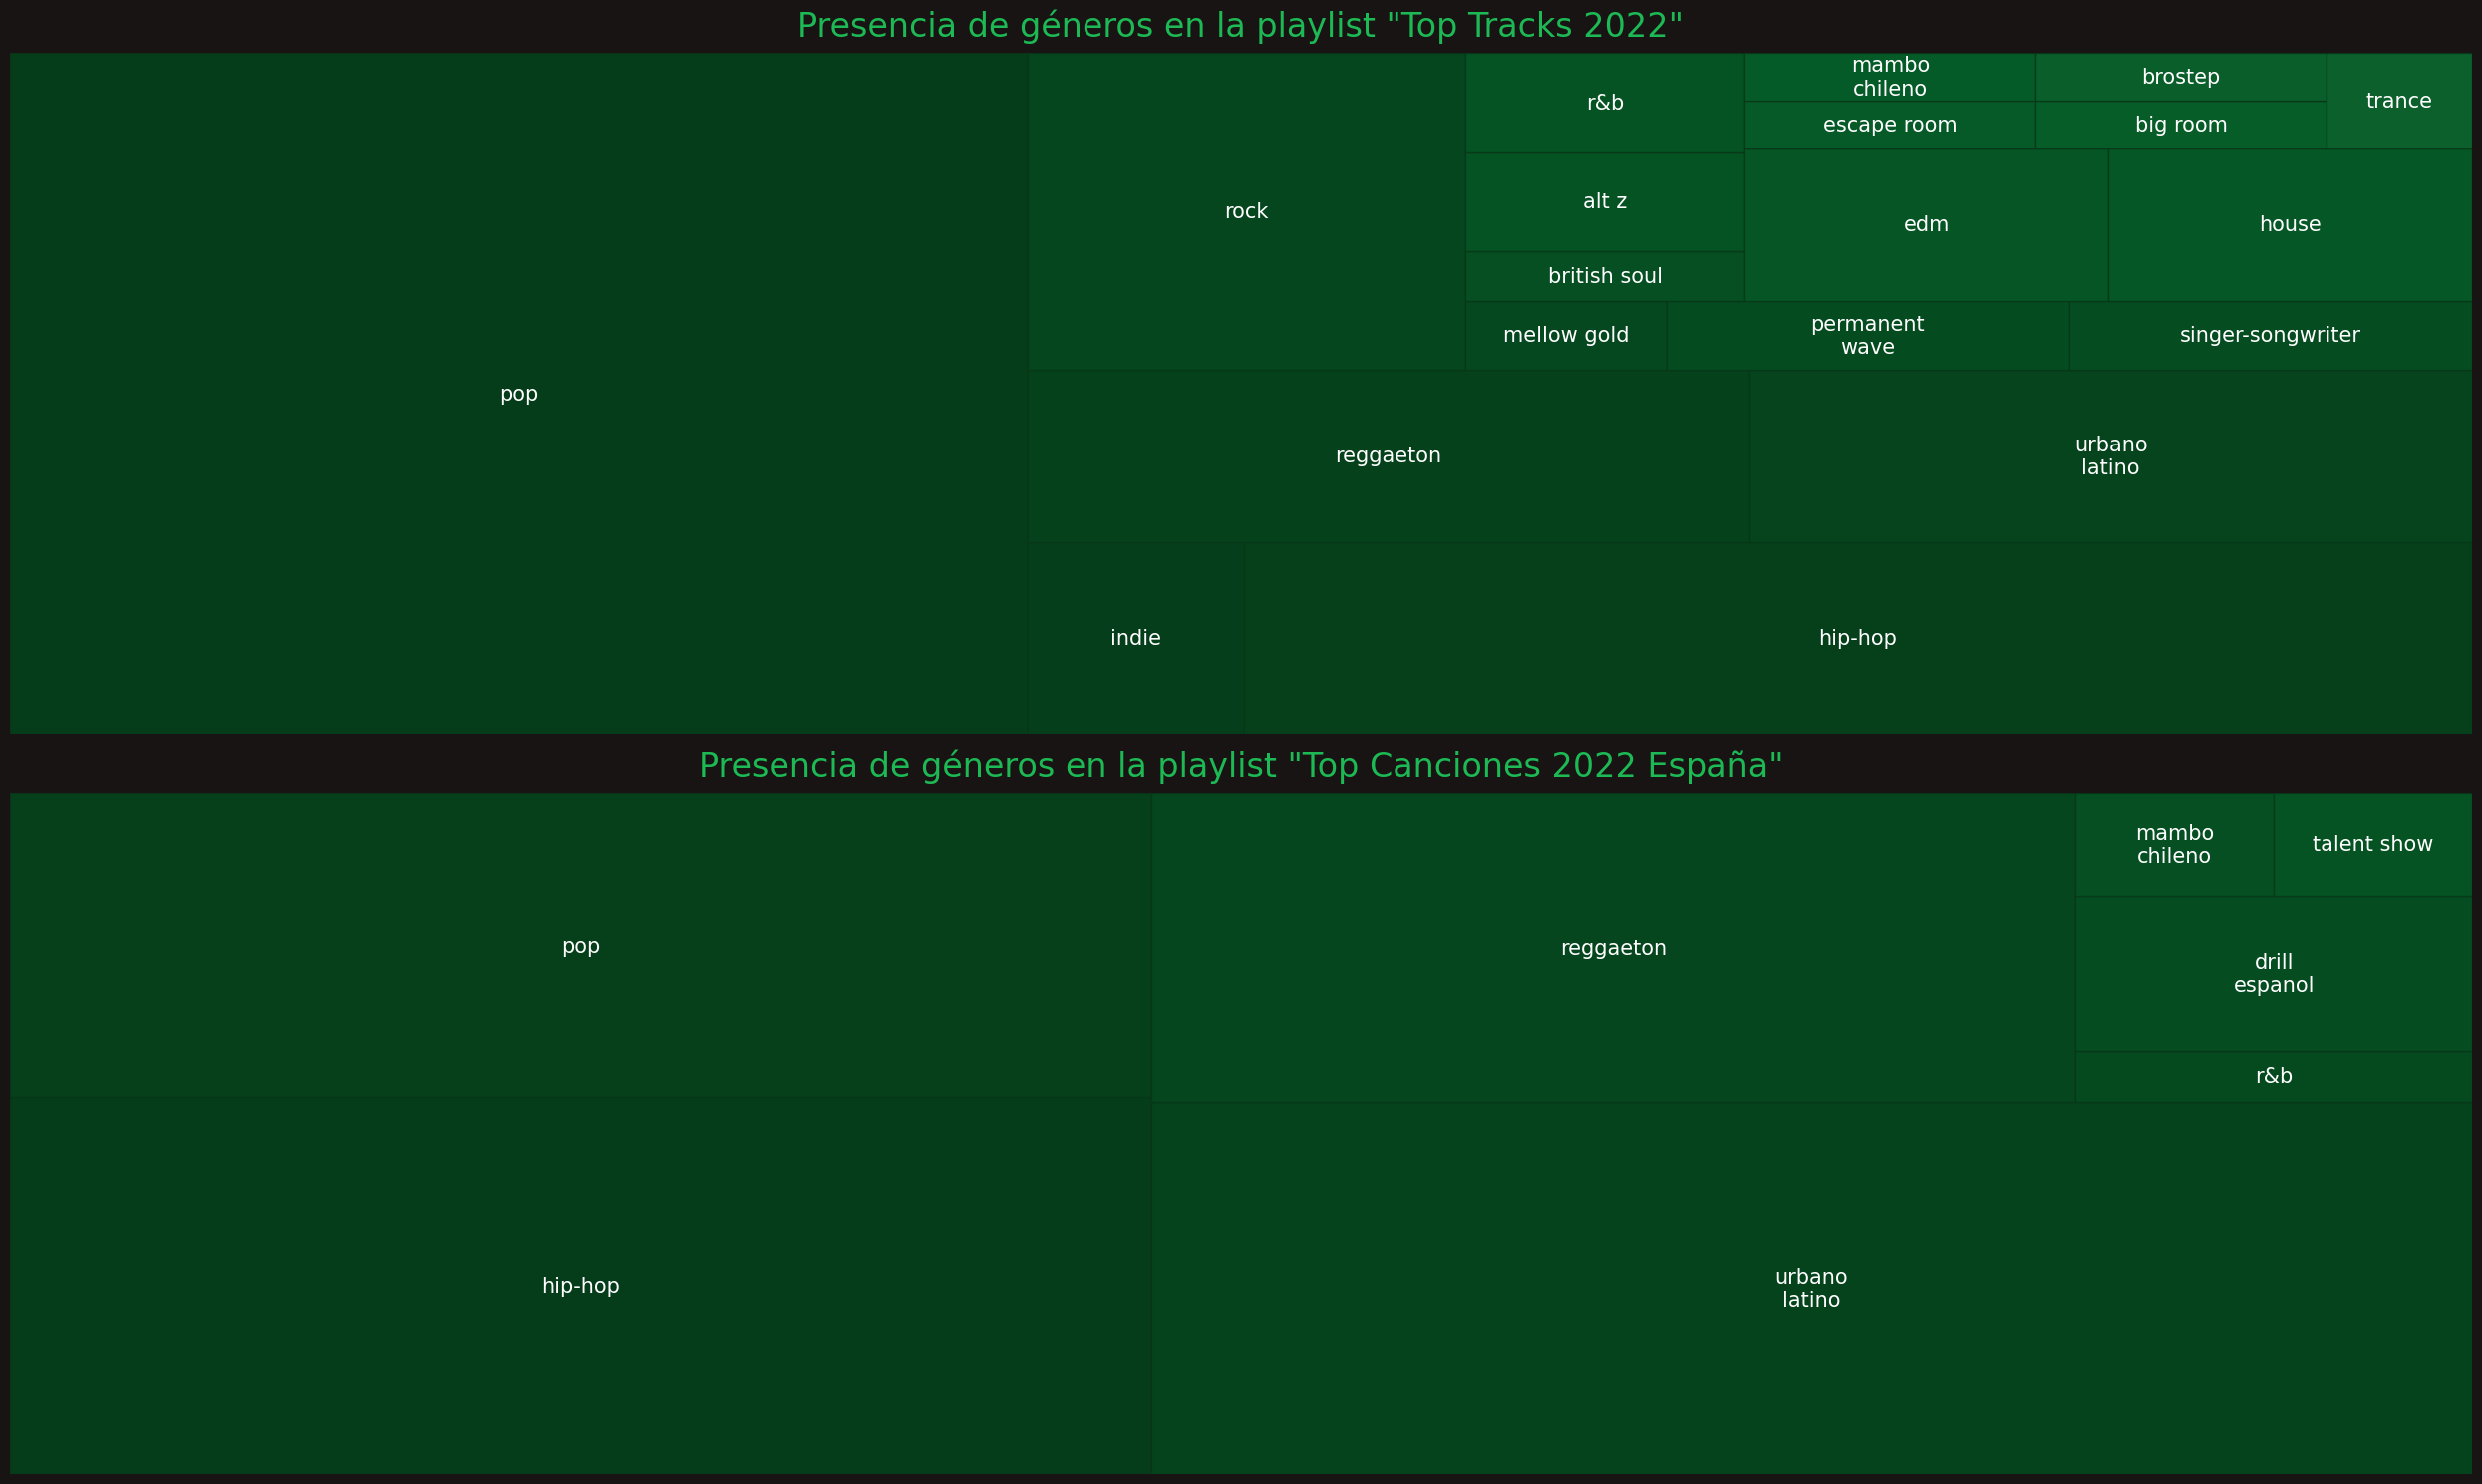

In [121]:
# PLOT DE LAS DOS
fig = plt.figure(figsize=(25, 15))
fig.patch.set_facecolor('#191414') # FONDO DEL GRÁFICO

plt.subplot(2, 1, 1)
squarify.plot(
    sizes=sizes_world, 
    label=genre_count_world.keys(), 
    color=sns.color_palette("Greens_r", len(genres_world)),
    ec = '#093618', # BORDES DE LOS CUADROS
    text_kwargs = {'fontsize': 15, 'color': 'white'},
    alpha = 0.8,
    )
plt.title('Presencia de géneros en la playlist "Top Tracks 2022"', fontsize=24, color = '#1DB954', pad=12)
plt.axis("off")

plt.subplot(2, 1, 2)
squarify.plot(
    sizes=sizes_spain, 
    label=genre_count_spain.keys(), 
    color=sns.color_palette("Greens_r", len(genres_spain)),
    ec = '#093618', # BORDES DE LOS CUADROS
    text_kwargs = {'fontsize': 15, 'color': 'white'},
    alpha = 0.8,
    )
plt.title('Presencia de géneros en la playlist "Top Canciones 2022 España"', fontsize=24, color = '#1DB954', pad=12)
plt.axis("off")

fig.tight_layout()
plt.show()

#### ARTISTAS
Visualizamos la distribución de artistas usando un treemap.

In [122]:
# ==== DATOS MUNDIALES
artists_world = []

for artist in df_track_by_artist_world['Track_Featured_Artist']:

    if len(artist) > 20:
        artist = artist.replace(' ', '\n')

    artists_world.append(artist)

# CREO LA CUENTA PARA LOS TAMAÑOS
artist_count_world = {}

for artist in artists_world:
    if artist in artist_count_world:
        artist_count_world[artist] += 1
    else:
        artist_count_world[artist] = 1

# DEFINO LOS TAMAÑOS SEGUN EL METODO DE SQUARIFY
sizes_artist_world = [artist_count_world[artist] for artist in artist_count_world]

# ==== DATOS ESPAÑA 
artists_spain = []

for artist in df_track_by_artist_spain['Track_Featured_Artist']:

    if len(artist) > 15:
        artist = artist.replace(' ', '\n')

    artists_spain.append(artist)

# CREO LA CUENTA PARA LOS TAMAÑOS
artist_count_spain = {}

for artist in artists_spain:
    if artist in artist_count_spain:
        artist_count_spain[artist] += 1
    else:
        artist_count_spain[artist] = 1

# DEFINO LOS TAMAÑOS SEGUN EL METODO DE SQUARIFY
sizes_artist_spain = [artist_count_spain[artist] for artist in artist_count_spain]

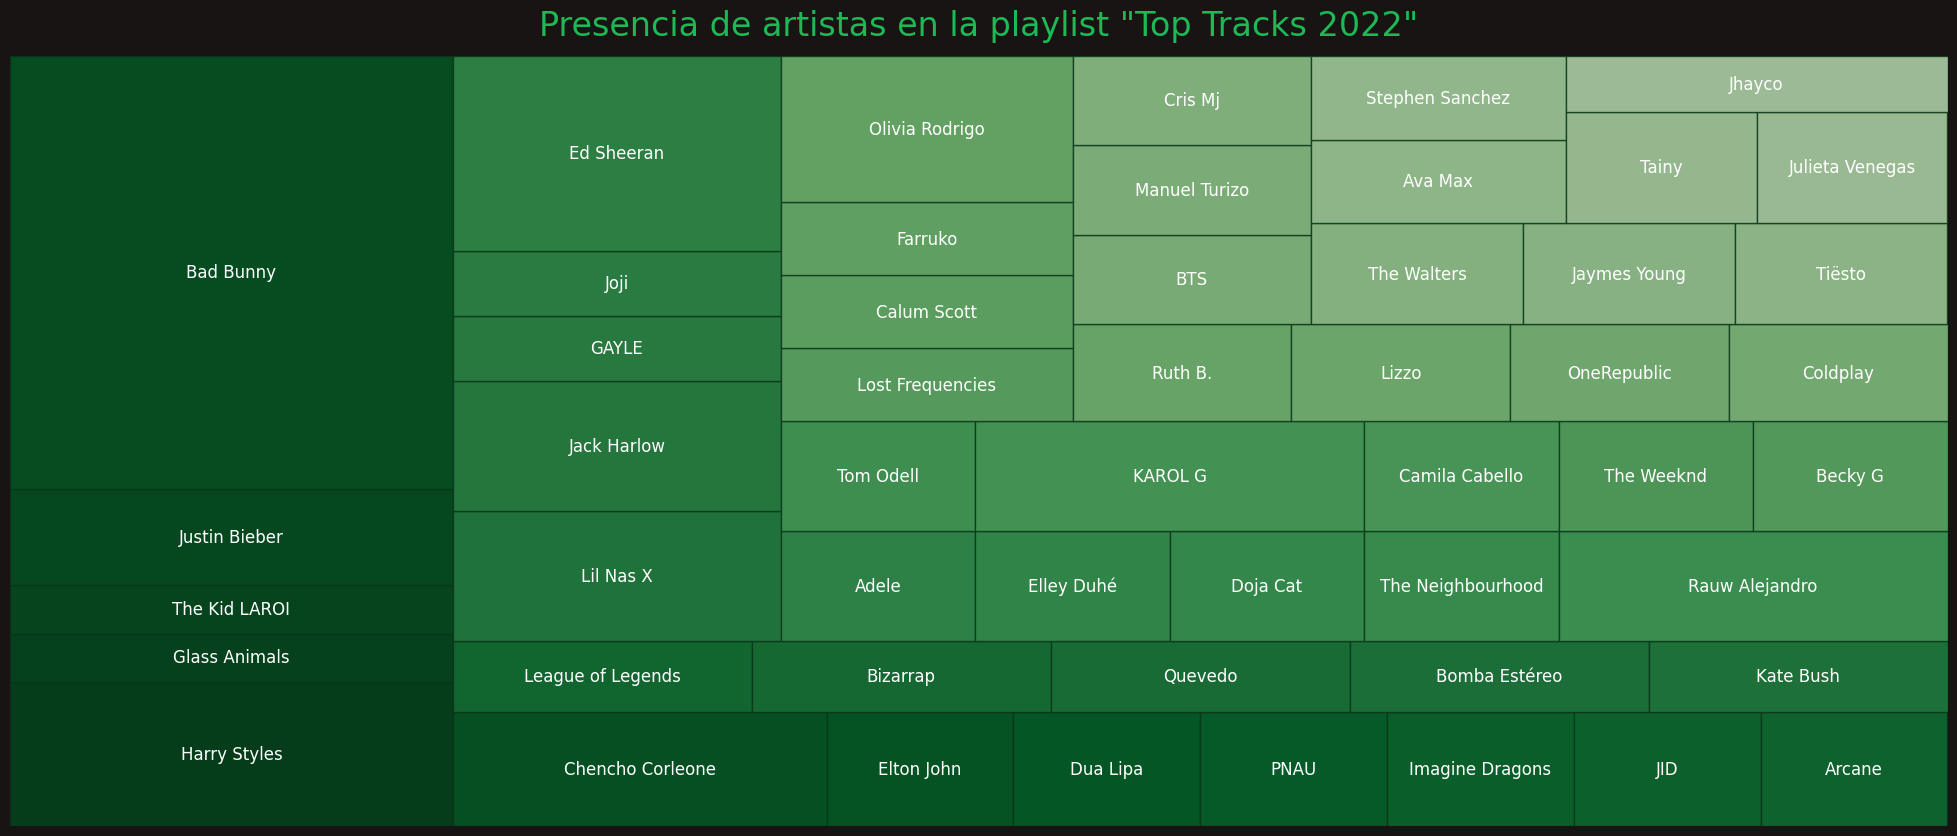

In [123]:
# PLOT MUNDIAL
fig = plt.figure(figsize=(25, 10))
fig.patch.set_facecolor('#191414') # FONDO DEL GRÁFICO
plt.axis("off")
squarify.plot(
    sizes=sizes_artist_world, 
    label=artist_count_world.keys(), 
    color=sns.color_palette("Greens_r", len(artists_world)),
    ec = '#093618', # BORDES DE LOS CUADROS
    text_kwargs = {'fontsize': 12, 'color': 'white'},
    alpha = 0.8,
    )
plt.title('Presencia de artistas en la playlist "Top Tracks 2022"', fontsize=24, color = '#1DB954', pad=15)
plt.show()

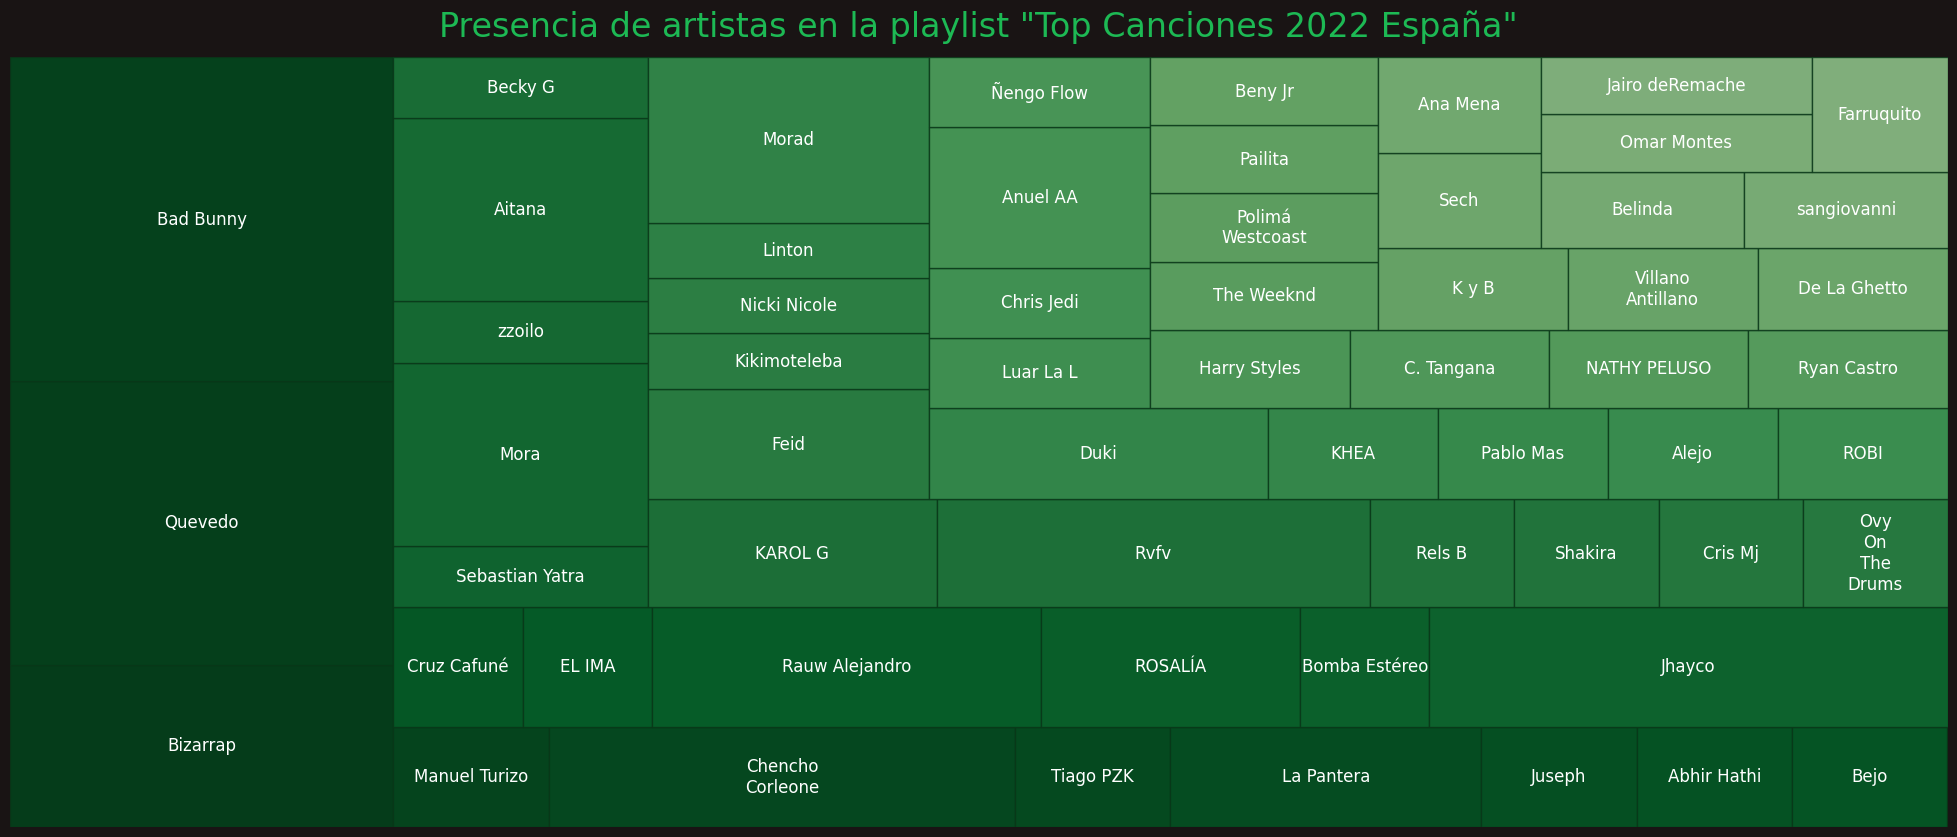

In [124]:
# PLOT ESPAÑA
fig = plt.figure(figsize=(25, 10))
fig.patch.set_facecolor('#191414') # FONDO DEL GRÁFICO
plt.axis("off")
squarify.plot(
    sizes=sizes_artist_spain, 
    label=artist_count_spain.keys(), 
    color=sns.color_palette("Greens_r", len(artists_spain)),
    ec = '#093618', # BORDES DE LOS CUADROS
    text_kwargs = {'fontsize': 12, 'color': 'white'},
    alpha = 0.8,
    )
plt.title('Presencia de artistas en la playlist "Top Canciones 2022 España"', fontsize=24, color = '#1DB954', pad=15)
plt.show()

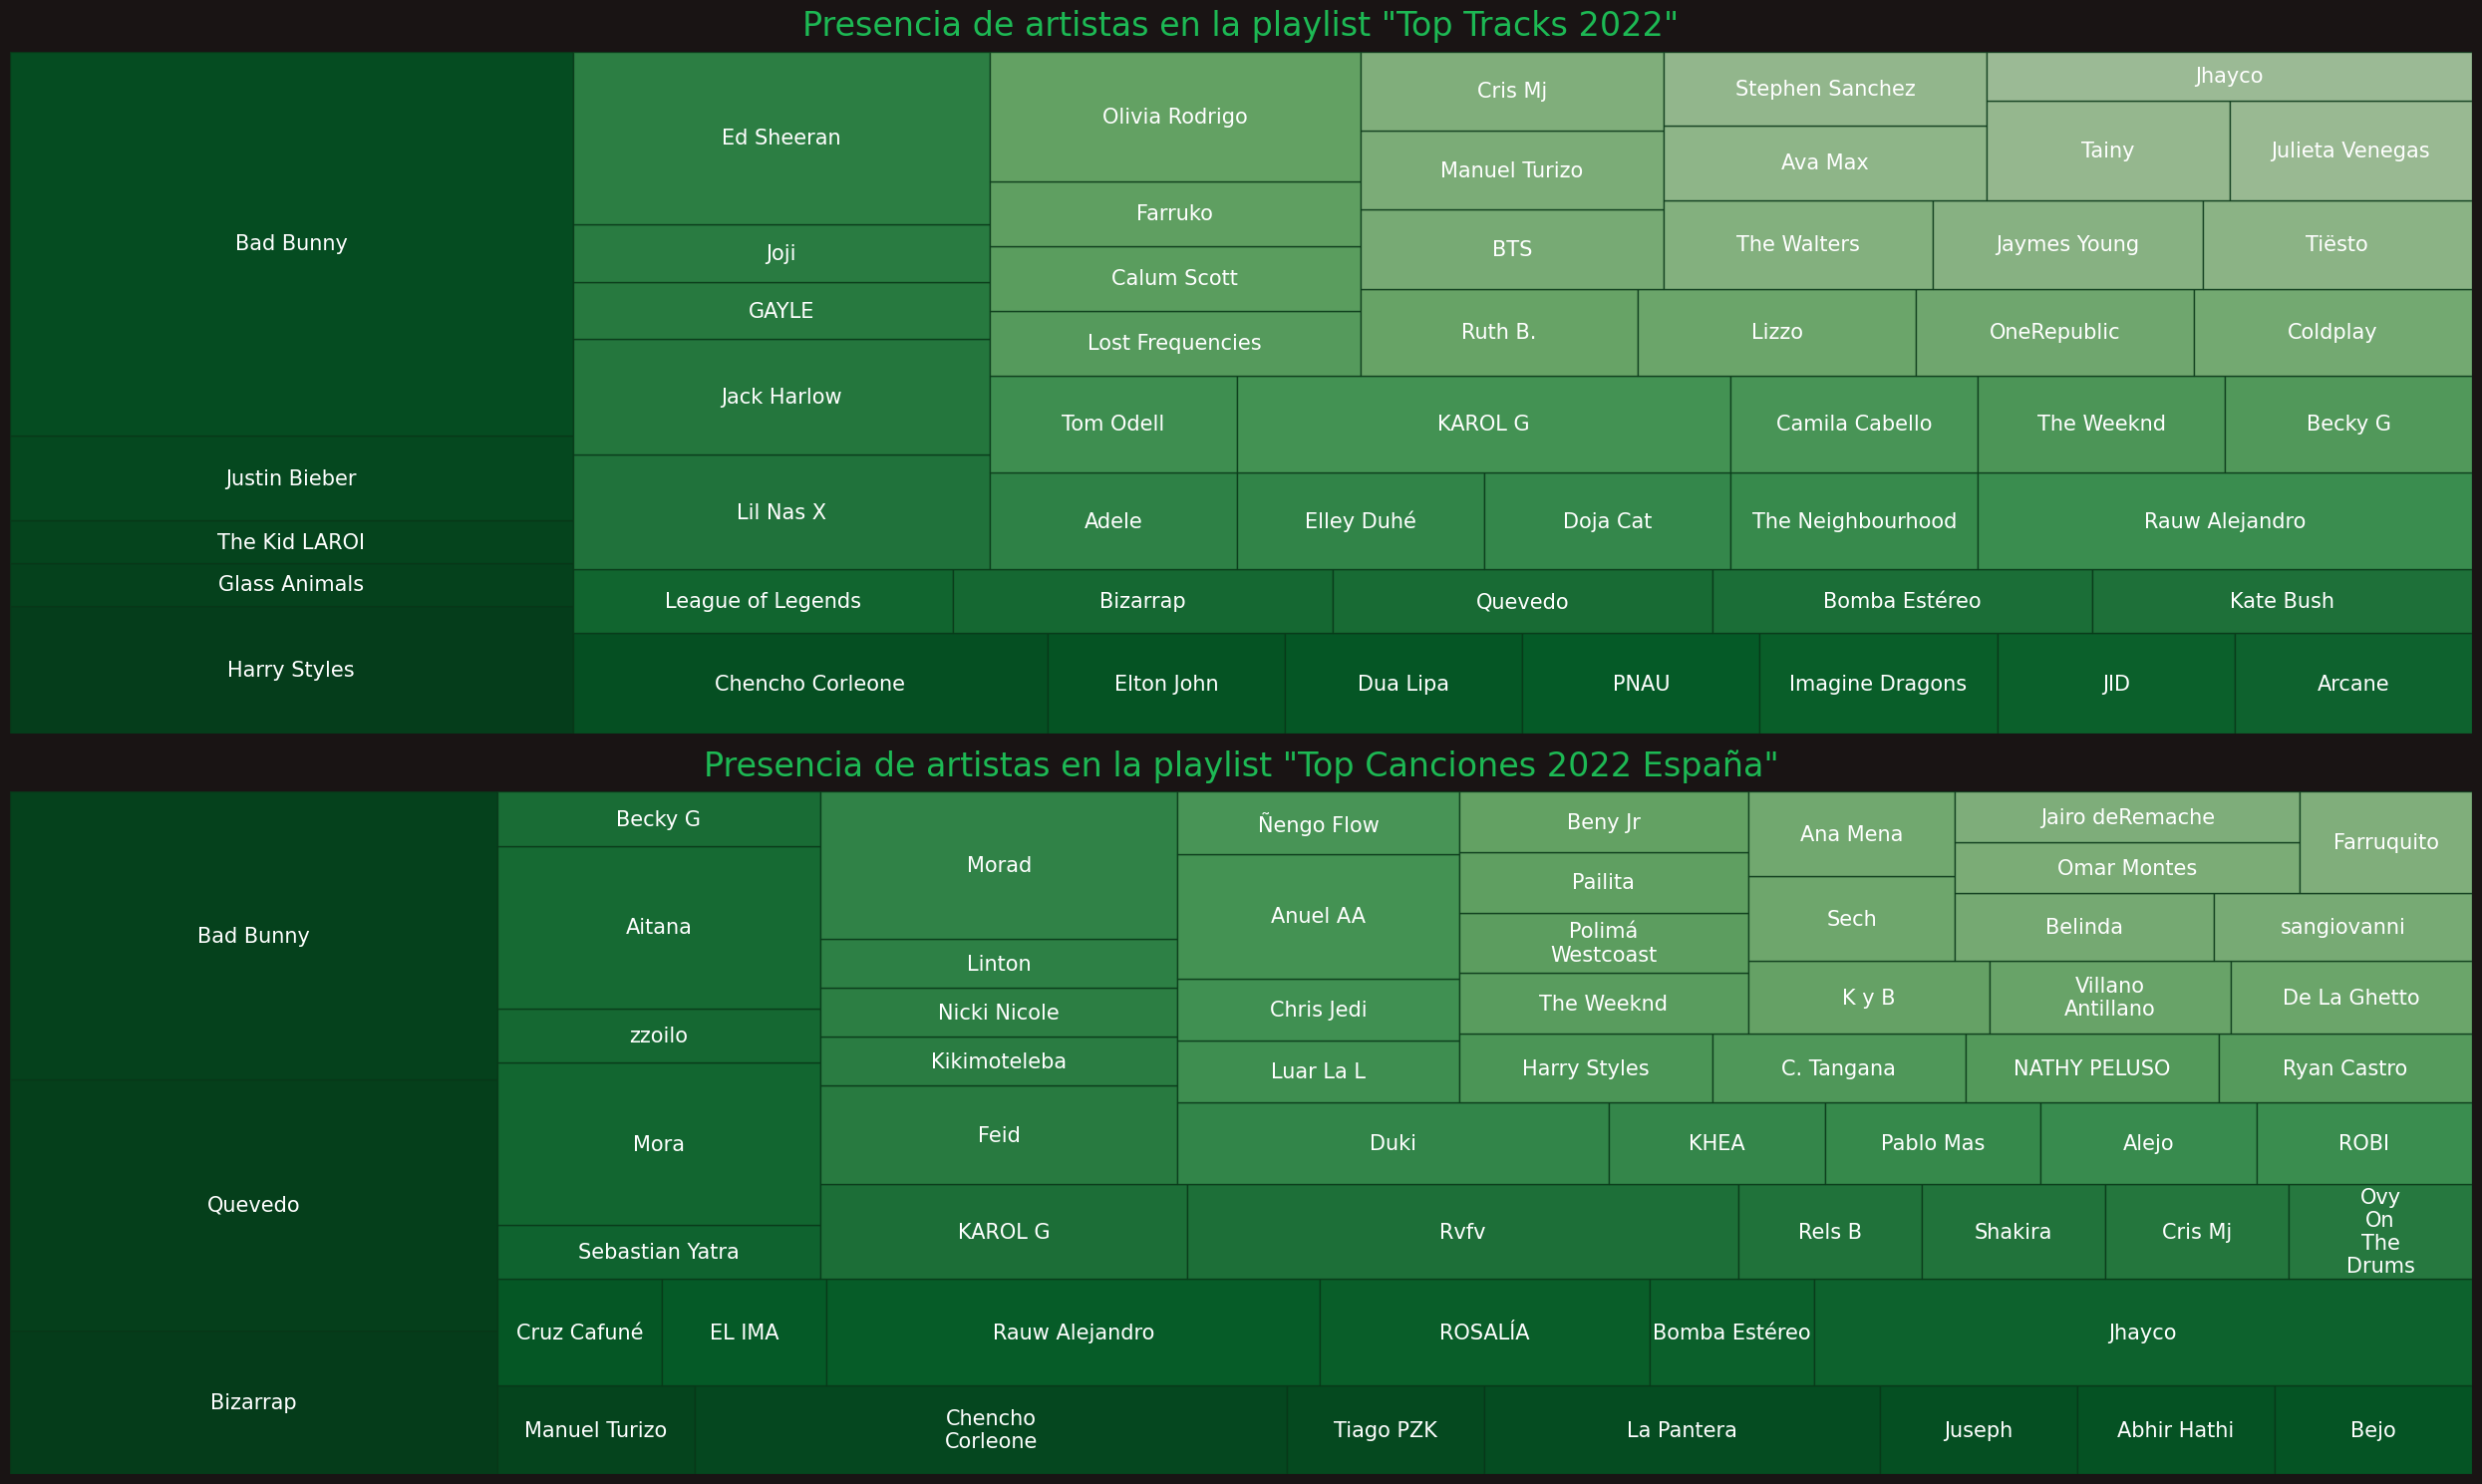

In [125]:
# PLOT DE LAS DOS
fig = plt.figure(figsize=(25, 15))
fig.patch.set_facecolor('#191414') # FONDO DEL GRÁFICO

plt.subplot(2, 1, 1)
squarify.plot(
    sizes=sizes_artist_world, 
    label=artist_count_world.keys(), 
    color=sns.color_palette("Greens_r", len(artists_world)),
    ec = '#093618', # BORDES DE LOS CUADROS
    text_kwargs = {'fontsize': 15, 'color': 'white'},
    alpha = 0.8,
    )
plt.title('Presencia de artistas en la playlist "Top Tracks 2022"', fontsize=24, color = '#1DB954', pad=12)
plt.axis("off")

plt.subplot(2, 1, 2)
squarify.plot(
    sizes=sizes_artist_spain, 
    label=artist_count_spain.keys(), 
    color=sns.color_palette("Greens_r", len(artists_spain)),
    ec = '#093618', # BORDES DE LOS CUADROS
    text_kwargs = {'fontsize': 15, 'color': 'white'},
    alpha = 0.8,
    )
plt.title('Presencia de artistas en la playlist "Top Canciones 2022 España"', fontsize=24, color = '#1DB954', pad=12)
plt.axis("off")

fig.tight_layout()
plt.show()

#### CORRELACIÓN DE PARÁMETROS

In [126]:
df_correlate_world = pd.merge(df_analysis_info_world, df_additional_info_world[['Track_ID','Track_Popularity']], on='Track_ID')
df_correlate_spain = pd.merge(df_analysis_info_spain, df_additional_info_spain[['Track_ID','Track_Popularity']], on='Track_ID')

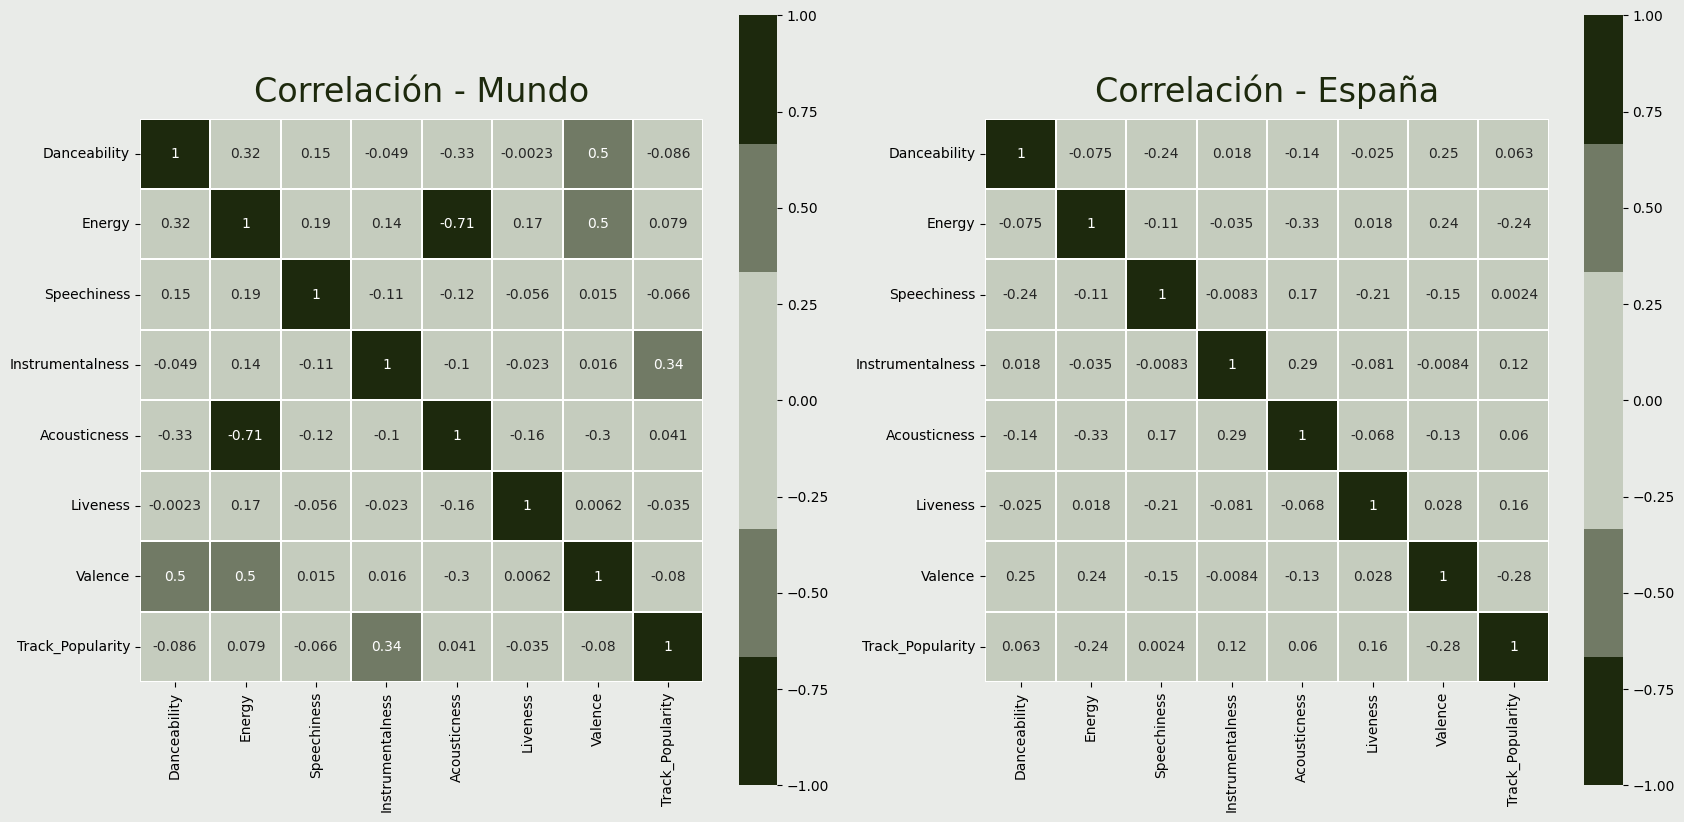

In [127]:
# SACO EL HEATMAP PARA EVALUAR

# PLOT DE LAS DOS
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('#e9ebe8') # FONDO DEL GRÁFICO

plt.subplot(1, 2, 1)
sns.heatmap(df_correlate_world.loc[:, 'Danceability':'Track_Popularity'].corr(),
            vmin=-1,
            vmax=1,
            cmap=sns.diverging_palette(110, 110, s=75, l=15, n=6),
            # cmap='Greens',
            square=True,
            linewidths=.1,
            annot=True);
plt.title('Correlación - Mundo', fontsize=24, color = '#1d290d', pad=12)

plt.subplot(1, 2, 2)
sns.heatmap(df_correlate_spain.loc[:, 'Danceability':'Track_Popularity'].corr(),
            vmin=-1,
            vmax=1,
            cmap=sns.diverging_palette(110, 110, s=75, l=15, n=6),
            # cmap='Greens',
            square=True,
            linewidths=.1,
            annot=True);
plt.title('Correlación - España', fontsize=24, color = '#1d290d', pad=12)

plt.show()

Mundial ->
1. No existen apenas correlaciones fuertes, ni positivas ni negativas (Por encima de ±0.70)
2. Tenemos una correlación fuerte descendiente (-0.71): Entre la Energy y Acousticness. Atendiendo a las descripciones de los parámetros tiene mucho sentido, ya que mientras menos acústica, más enérgica será la canción. De todas formas, no es una relación que nos sirva para nuestro estudio.
3. Trabajando sobre la popularidad de la canción, que es el factor que nos interesa, solo tendríamos una correlación débil: Ascendente (0.34) frente a la instrumentalidad de la canción. El oyente mundial promedio sí valora más positivamente que la canción sea más instrumental.

España ->
1. En España no tenemos ninguna correlación ni siquiera moderada en la popularidad de los temas, el valor máximo es de -0.33.
2. En este rango observamos que curiosamente tienen más popularidad las canciones con una valencia y una energía más bajas: canciones más tristes y menos enérgicas. *(Eso explica lo de Álex Ubago)*.

Conclusión final:
No podemos correlacionar la popularidad de la canción a ningún parámetro ya que no obtenemos valores fuertes.

#### ANÁLISIS DE LAS TENDENCIAS

Dado que no podemos correlacionar la popularidad con los parámetros de forma concluyente, procederemos a darle forma a la canción tipo analizando los valores.

In [128]:
df_analysis_info_world.describe()

,Duracion_MS,Loudness_dB,Clave,Modo,Tempo_BPM,Compas,Danceability,Energy,Speechiness,Instrumentalness,Acousticness,Liveness,Valence
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,203046.180000,-5.763960,5.380000,0.480000,120.620160,3.920000,0.688380,0.672540,0.069220,0.001385,0.235453,0.178700,0.491696
std,37317.131075,1.811174,3.697158,0.504672,29.315149,0.274048,0.134633,0.129002,0.052516,0.005333,0.243318,0.137624,0.248094
min,141806.000000,-11.903000,0.000000,0.000000,75.977000,3.000000,0.380000,0.317000,0.025900,0.000000,0.001460,0.042400,0.084900
25%,173522.750000,-6.365250,2.000000,0.000000,98.527250,4.000000,0.601750,0.617250,0.040225,0.000000,0.040000,0.090600,0.302000
50%,206390.500000,-5.516000,5.000000,0.000000,115.514000,4.000000,0.699500,0.698500,0.048800,0.000003,0.116500,0.116500,0.468000
75%,230367.000000,-4.596500,9.000000,1.000000,137.495750,4.000000,0.799750,0.763750,0.080075,0.000066,0.340250,0.239000,0.635750
max,300840.000000,-2.724000,11.000000,1.000000,185.727000,4.000000,0.911000,0.893000,0.266000,0.033000,0.891000,0.658000,0.956000


Vamos a trabajar sobre cuatro campos:
- Tempo
- Danceability
- Acousticness
- Valence

In [129]:
df_trend_world = df_analysis_info_world[['Track_ID', 'Tempo_BPM', 'Danceability', 'Acousticness', 'Valence']]
df_trend_spain = df_analysis_info_spain[['Track_ID', 'Tempo_BPM', 'Danceability', 'Acousticness', 'Valence']]

Analizamos la distribución, para ver si hay outliers

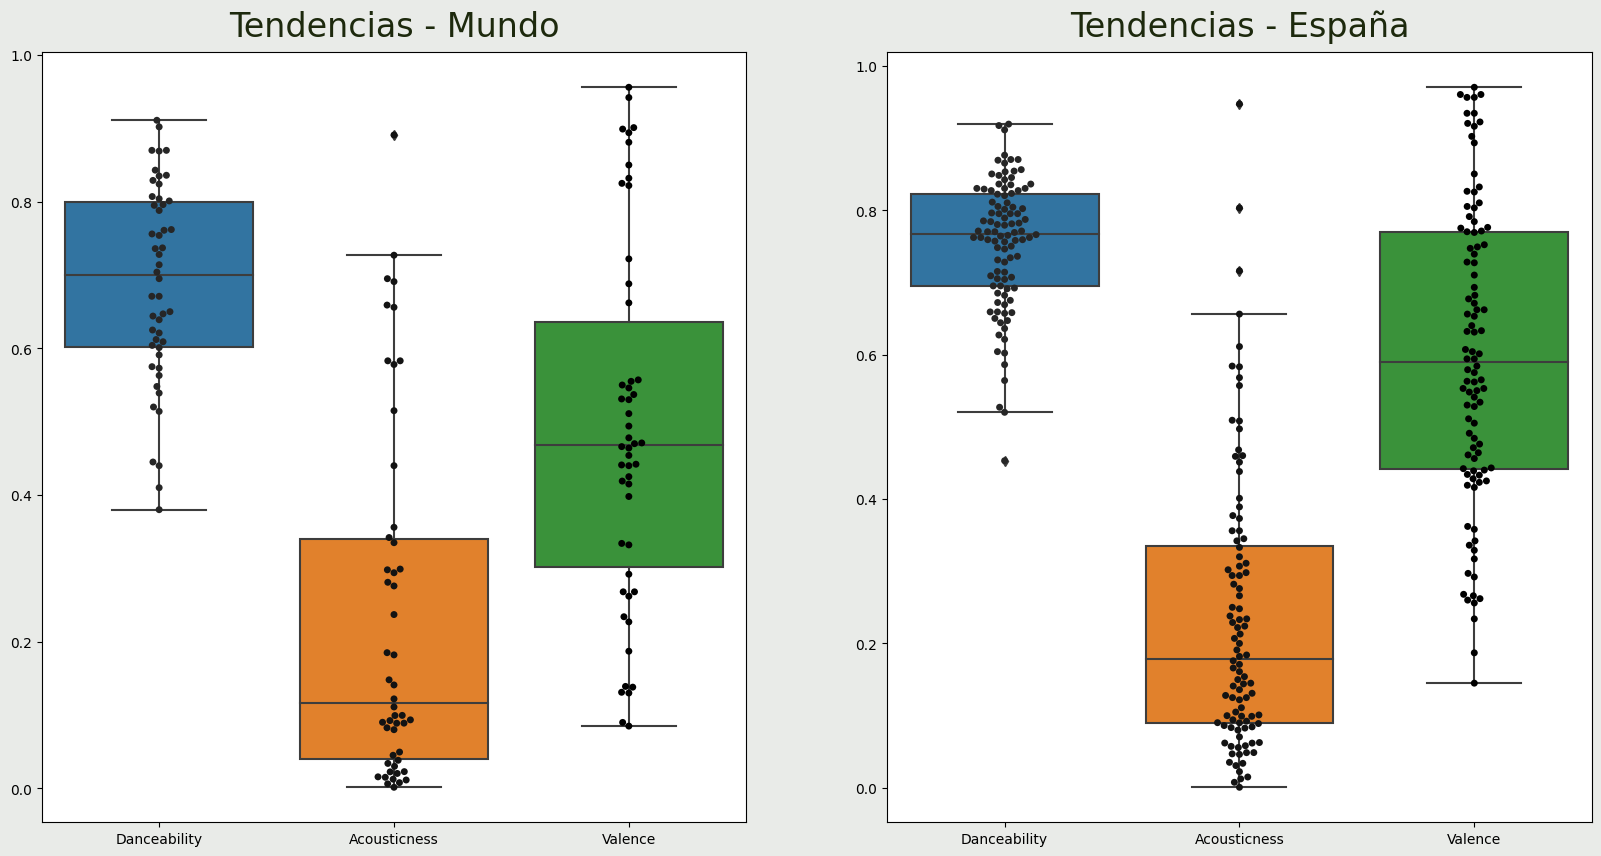

In [130]:
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('#e9ebe8') # FONDO DEL GRÁFICO

plt.subplot(1, 2, 1)
sns.boxplot(data=df_trend_world.loc[:, 'Danceability':])
sns.swarmplot(data=df_trend_world.loc[:, 'Danceability':], color="black", edgecolor="gray");
plt.title('Tendencias - Mundo', fontsize=24, color = '#1d290d', pad=12)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_trend_spain.loc[:, 'Danceability':])
sns.swarmplot(data=df_trend_spain.loc[:, 'Danceability':], color="black", edgecolor="gray");
plt.title('Tendencias - España', fontsize=24, color = '#1d290d', pad=12)

plt.show()

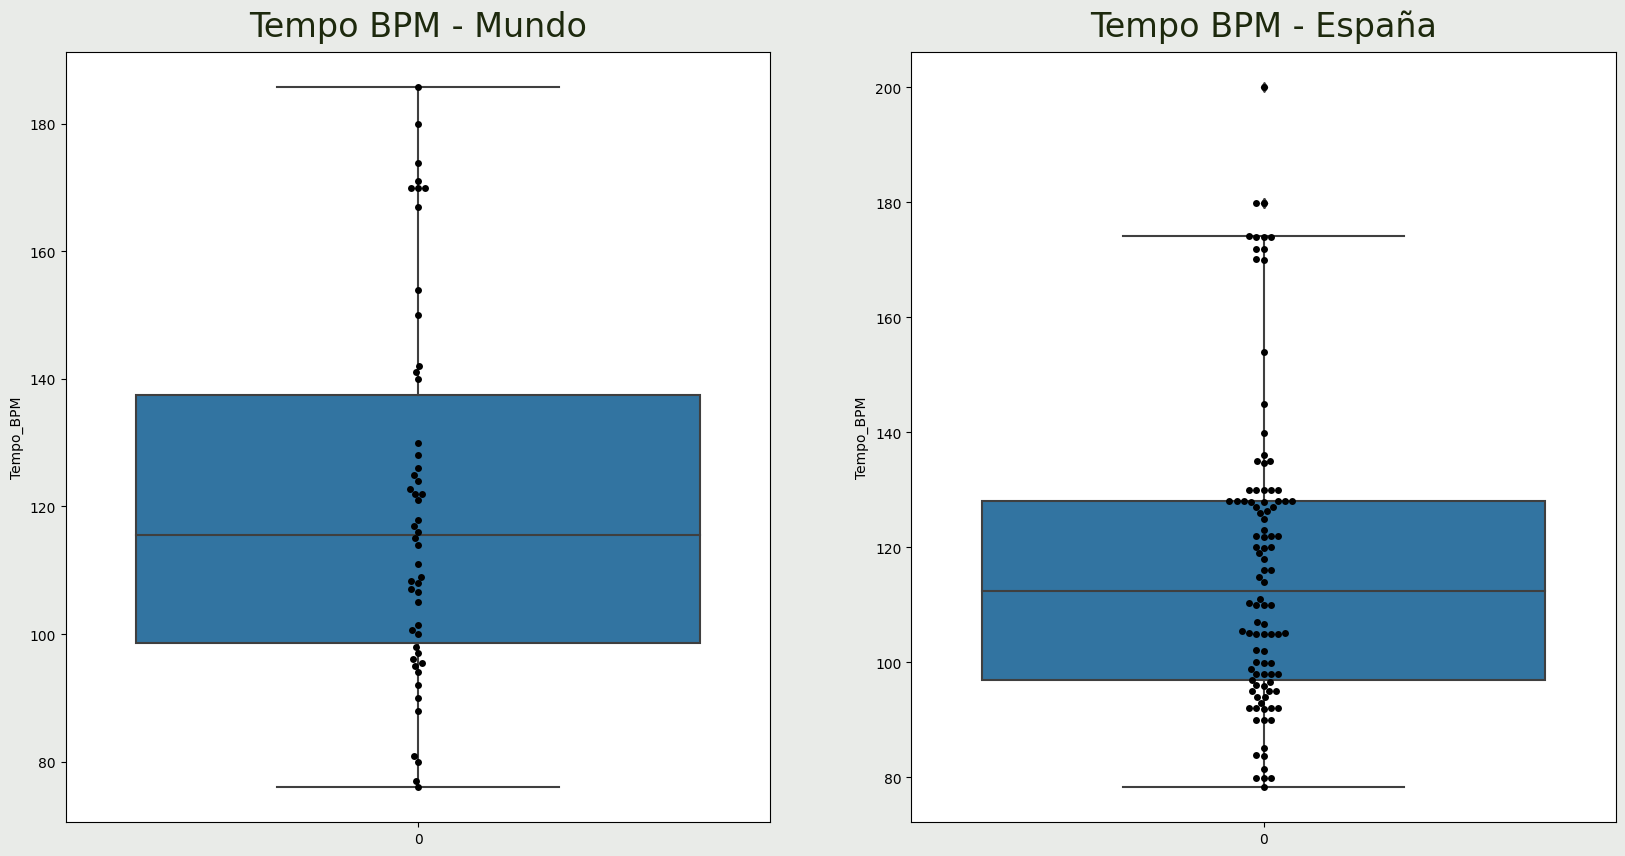

In [131]:
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('#e9ebe8') # FONDO DEL GRÁFICO

plt.subplot(1, 2, 1)
sns.boxplot(data=df_trend_world['Tempo_BPM'])
sns.swarmplot(data=df_trend_world['Tempo_BPM'], color="black", edgecolor="gray");
plt.title('Tempo BPM - Mundo', fontsize=24, color = '#1d290d', pad=12)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_trend_spain['Tempo_BPM'])
sns.swarmplot(data=df_trend_spain['Tempo_BPM'], color="black", edgecolor="gray");
plt.title('Tempo BPM - España', fontsize=24, color = '#1d290d', pad=12)

plt.show()

Tenemos que deshacernos de los outliers en Acousticness mundial, y Danceability y Acousticness de España. Usaremos el Rango intercuartílico (IQR).

In [132]:
df_trend_world_clean = df_trend_world.copy()
df_trend_spain_clean = df_trend_spain.copy()

In [133]:
# WORLD

# IQR
Q1 = np.percentile(df_trend_world_clean['Acousticness'], 25, interpolation = 'midpoint')
Q3 = np.percentile(df_trend_world_clean['Acousticness'], 75, interpolation = 'midpoint')
IQR = Q3 - Q1
print('IQR: ' + str(IQR))

# LIMITE SUPERIOR
superior = np.where(df_trend_world_clean['Acousticness'] >= (Q3+1.5*IQR))
# LIMITE INFERIOR
inferior = np.where(df_trend_world_clean['Acousticness'] <= (Q1-1.5*IQR))

# LIMPIAMOS USANDO MÁSCARAS
df_trend_world_clean.drop(superior[0], inplace = True)
df_trend_world_clean.drop(inferior[0], inplace = True)


IQR: 0.2968


In [134]:
# SPAIN

# IQR
Q1 = np.percentile(df_trend_spain_clean['Acousticness'], 25, interpolation = 'midpoint')
Q3 = np.percentile(df_trend_spain_clean['Acousticness'], 75, interpolation = 'midpoint')
IQR = Q3 - Q1
print('IQR: ' + str(IQR))

# LIMITE SUPERIOR
superior = np.where(df_trend_spain_clean['Acousticness'] >= (Q3+1.5*IQR))
# LIMITE INFERIOR
inferior = np.where(df_trend_spain_clean['Acousticness'] <= (Q1-1.5*IQR))

# LIMPIAMOS USANDO MÁSCARAS
df_trend_spain_clean.drop(superior[0], inplace = True)
df_trend_spain_clean.drop(inferior[0], inplace = True)

IQR: 0.2479


In [135]:
# IQR
Q1 = np.percentile(df_trend_spain_clean['Danceability'], 25, interpolation = 'midpoint')
Q3 = np.percentile(df_trend_spain_clean['Danceability'], 75, interpolation = 'midpoint')
IQR = Q3 - Q1
print('IQR: ' + str(IQR))

# LIMITE SUPERIOR
superior = np.where(df_trend_spain_clean['Danceability'] >= (Q3+1.5*IQR))
# LIMITE INFERIOR
inferior = np.where(df_trend_spain_clean['Danceability'] <= (Q1-1.5*IQR))

# LIMPIAMOS USANDO MÁSCARAS
df_trend_spain_clean.drop(superior[0], inplace = True)
df_trend_spain_clean.drop(inferior[0], inplace = True)

IQR: 0.128


(0.0, 1.0)

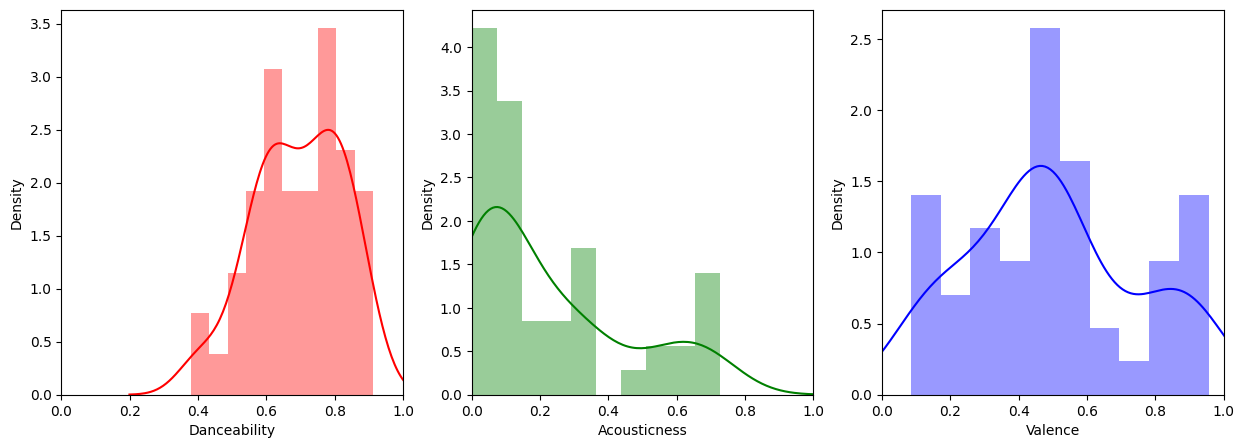

In [208]:
f, axes = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey = False)
sns.distplot(df_trend_world_clean["Danceability"] , color="red", label="Danceability", bins=10, ax=axes[0])
sns.distplot(df_trend_world_clean["Acousticness"] , color="green", label="Acousticness", bins=10, ax=axes[1])
sns.distplot(df_trend_world_clean["Valence"] , color="blue", label="Valence", bins=10, ax=axes[2])

# TODOS LOS PARÁMETROS VAN DE 0 A 1. LIMITO EL EJE X
axes[0].set_xlim(0,1)
axes[1].set_xlim(0,1)
axes[2].set_xlim(0,1)

In [222]:
# AL SER VALORES MÁS DISPERSOS COGEMOS LA MEDIANA
df_trend_world_clean.median()

Tempo_BPM       114.996
Danceability      0.704
Acousticness      0.111
Valence           0.470
dtype: float64

(0.0, 1.0)

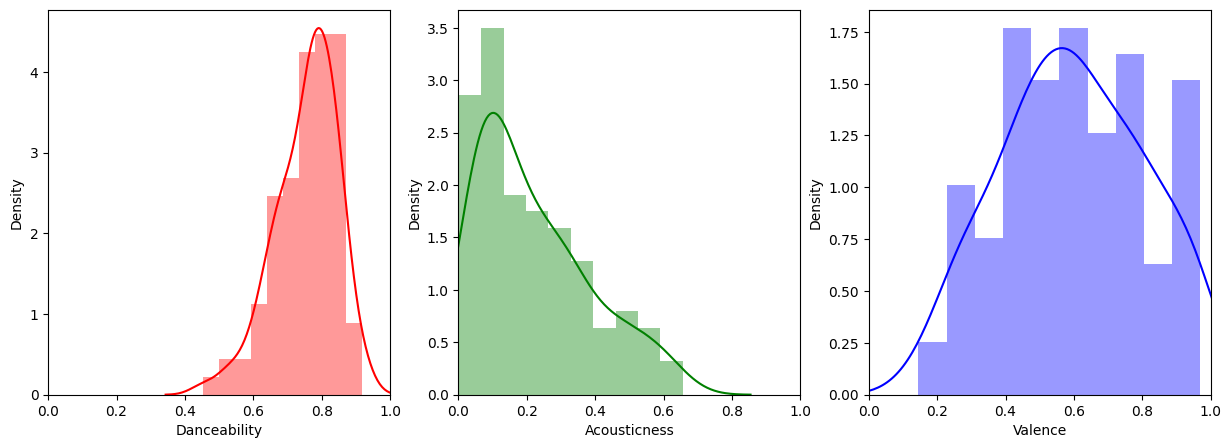

In [137]:
f, axes = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey = False)
sns.distplot(df_trend_spain_clean["Danceability"] , color="red", label="Danceability", bins=10, ax=axes[0])
sns.distplot(df_trend_spain_clean["Acousticness"] , color="green", label="Acousticness", bins=10, ax=axes[1])
sns.distplot(df_trend_spain_clean["Valence"] , color="blue", label="Valence", bins=10, ax=axes[2])

# TODOS LOS PARÁMETROS VAN DE 0 A 1. LIMITO EL EJE X
axes[0].set_xlim(0,1)
axes[1].set_xlim(0,1)
axes[2].set_xlim(0,1)

In [189]:
stats.mode(df_trend_spain_clean)

ModeResult(mode=array([['03a359wbiUsjN9h6yzXvmS', 90.02, 0.795, 0.125, 0.553]],
      dtype=object), count=array([[1, 2, 3, 2, 2]]))

### Conclusión final: Tendencias


A nivel español, obtenemos que la canción promedio es una canción latina, en torno a 90 BPM, muy bailable (0.8), con mucha presencia electrónica (0.1) y con un mood intermedio entre alegre y triste. 

>Un ejemplo con estos parámetros es:
>- Bad Bunny ft. Chencho Corleone - Me porto bonito


A nivel mundial, obtenemos que la canción promedio es una canción pop, en torno a 115 BPM, moderadamente bailable (0.7), con mucha presencia electrónica (0.1) y con un mood intermedio entre alegre y triste. 

>Un ejemplo con estos parámetros es:
>- Ruth B. - Dandelions

### RESUMEN DE DATOS - Popularidad y conciertos

>**concerts_world** -> Track_Main_Artist, Fecha, Ciudad, Pais<br>
>**concerts_spain** -> Track_Main_Artist, Fecha, Ciudad, Pais

Combinamos los dataframes:

In [139]:
# CONCIERTOS
df_concerts_world = pd.read_csv('../data/concerts_world.csv', sep=';')
df_concerts_spain = pd.read_csv('../data/concerts_spain.csv', sep=';')

display('df_concerts_world.head()', 'df_concerts_spain.head()')

,Track_Main_Artist,Fecha,Ciudad,Pais
0,Adele,2022-12-31,Las Vegas,US
1,Adele,2022-12-30,Las Vegas,US
2,Adele,2022-12-24,Las Vegas,US
3,Adele,2022-12-23,Las Vegas,US
4,Adele,2022-12-17,Las Vegas,US
,Track_Main_Artist,Fecha,Ciudad,Pais
0,Aitana,2022-12-20,Madrid,Spain
1,Aitana,2022-11-16,Santiago,Chile
2,Aitana,2022-11-04,Madrid,Spain
3,Aitana,2022-10-15,Monterrey,Mexico


In [140]:
# INFO SOBRE ARTISTAS
display('df_artist_info_world.head()', 'df_artist_info_spain.head()')

,Artist_ID,Artist,Followers_Spotify,Genres_List,Artist_Popularity
0,6KImCVD70vtIoJWnq6nGn3,Harry Styles,25357650,[pop],90
1,4yvcSjfu4PC0CYQyLy4wSq,Glass Animals,3576570,"[gauze pop, indietronica, shiver pop]",79
2,2tIP7SsRs7vjIcLrU85W8J,The Kid LAROI,4167326,"[australian hip hop, pop]",82
3,4q3ewBCX7sLwd24euuV69X,Bad Bunny,62302770,"[reggaeton, trap latino, urbano latino]",100
4,3PhoLpVuITZKcymswpck5b,Elton John,10725977,"[glam rock, mellow gold, piano rock]",86
,Artist_ID,Artist,Followers_Spotify,Genres_List,Artist_Popularity
0,716NhGYqD1jl2wI1Qkgq36,Bizarrap,8381159,"[argentine hip hop, pop venezolano, trap argen...",86
1,4q3ewBCX7sLwd24euuV69X,Bad Bunny,62302770,"[reggaeton, trap latino, urbano latino]",100
2,0tmwSHipWxN12fsoLcFU3B,Manuel Turizo,11141706,"[colombian pop, reggaeton, reggaeton colombian...",85
3,0IEzMvarfVycBJAXjjEZOL,La Pantera,26708,[rap canario],64


Nos quedamos con la popularidad de Spotify y los seguidores en la plataforma.

In [141]:
df_popularity_world = df_artist_info_world[['Artist', 'Followers_Spotify', 'Artist_Popularity']]
df_popularity_world.sort_values(by=['Artist_Popularity'], inplace = True, ascending=False)
df_popularity_world.reset_index(drop=True, inplace=True)

df_popularity_spain = df_artist_info_spain[['Artist', 'Followers_Spotify', 'Artist_Popularity']]
df_popularity_spain.sort_values(by=['Artist_Popularity'], inplace = True, ascending=False)
df_popularity_spain.reset_index(drop=True, inplace=True)

display('df_popularity_world.head()', 'df_popularity_spain.head()')

,Artist,Followers_Spotify,Artist_Popularity
0,Bad Bunny,62302770,100
1,The Weeknd,55941037,96
2,Justin Bieber,68899812,92
3,Ed Sheeran,107397209,91
4,Harry Styles,25357650,90
,Artist,Followers_Spotify,Artist_Popularity
0,Bad Bunny,62302770,100
1,Rauw Alejandro,15009769,90
2,Harry Styles,25357650,90
3,Shakira,26097826,87


Sacamos cuantos conciertos han dado en 2022.

In [142]:
# CONCIERTOS POR ARTISTA
df_num_concerts_world = df_concerts_world.groupby('Track_Main_Artist')[['Fecha']].count()
df_num_concerts_world.rename(columns = {'Fecha':'Conciertos'}, inplace = True)
df_num_concerts_world.sort_values(by=['Conciertos'], inplace = True, ascending=False)


df_num_concerts_spain = df_concerts_spain.groupby('Track_Main_Artist')[['Fecha']].count()
df_num_concerts_spain.rename(columns = {'Fecha':'Conciertos'}, inplace = True)
df_num_concerts_spain.sort_values(by=['Conciertos'], inplace = True, ascending=False)

display('df_num_concerts_world.head()', 'df_num_concerts_spain.head()')

,Conciertos
Track_Main_Artist,
Tiësto,93
Elton John,92
Lost Frequencies,92
Jack Harlow,92
Harry Styles,82
,Conciertos
Track_Main_Artist,
Elton John,92
Harry Styles,82


Cruzamos los dos dataframes para representar gráficamente las diferencias.

In [143]:
# CRUZO POPULARIDAD X CONCIERTOS

df_engagement_world = df_popularity_world.merge(df_num_concerts_world, left_on='Artist', right_on='Track_Main_Artist')
df_engagement_spain = df_popularity_spain.merge(df_num_concerts_spain, left_on='Artist', right_on='Track_Main_Artist')

display('df_engagement_world.head()', 'df_engagement_spain.head()')

,Artist,Followers_Spotify,Artist_Popularity,Conciertos
0,Bad Bunny,62302770,100,80
1,The Weeknd,55941037,96,24
2,Justin Bieber,68899812,92,52
3,Ed Sheeran,107397209,91,64
4,Harry Styles,25357650,90,82
,Artist,Followers_Spotify,Artist_Popularity,Conciertos
0,Bad Bunny,62302770,100,80
1,Rauw Alejandro,15009769,90,28
2,Harry Styles,25357650,90,82
3,Shakira,26097826,87,69


In [144]:
#  CREO LA TRACE 1
trace1 = go.Scatter(
    x=df_engagement_world['Artist'],
    y=df_engagement_world['Artist_Popularity'],
    name='Popularidad',
    mode='lines',
    marker=dict(color='#85BB65'),
    text=df_engagement_world['Artist'])

#  CREO LA TRACE 2
trace2 = go.Bar(
    x=df_engagement_world['Artist'],
    y=df_engagement_world['Conciertos'],
    name='Conciertos',
    marker=dict(color='#734182', line=dict(color='rgb(0,0,0)', width=1)))

data = [trace1, trace2]

layout = dict(title='Engagement con artistas - World')

fig = go.Figure(data=data, layout=layout)

iplot(fig)


Veamos ahora como se distribuye por paises.

In [145]:
df_concerts_country_world = df_concerts_world.groupby(['Track_Main_Artist', 'Pais'])[['Fecha']].count()
df_concerts_country_world.rename(columns = {'Fecha':'Conciertos'}, inplace = True)
df_concerts_country_world.sort_values(['Track_Main_Artist','Conciertos', 'Pais'], ascending = [True, False, True], inplace = True)


df_concerts_country_spain = df_concerts_spain.groupby(['Track_Main_Artist', 'Pais'])[['Fecha']].count()
df_concerts_country_spain.rename(columns = {'Fecha':'Conciertos'}, inplace = True)
df_concerts_country_spain.sort_values(['Track_Main_Artist','Conciertos', 'Pais'], ascending = [True, False, True], inplace = True)

display('df_concerts_country_world.head()', 'df_concerts_country_spain.head()')

df_concerts_country_world.head()
                          Conciertos
Track_Main_Artist Pais              
Adele             US              14
                  UK               4
Bad Bunny         US              59
                  Canada           3
                  Mexico           3

df_concerts_country_spain.head()
                          Conciertos
Track_Main_Artist Pais              
Aitana            Spain            8
                  Mexico           3
                  Chile            1
Bad Bunny         US              59
                  Canada           3

In [146]:
# RESETO INDEX PARA QUE LO COJA PX
df_concerts_country_world.reset_index(inplace=True)

fig = px.bar(
    df_concerts_country_world,
    x="Track_Main_Artist",
    y="Conciertos",
    color="Pais",
    title="Conciertos por País - Top World")
fig.show()

In [147]:
# RESETO INDEX PARA QUE LO COJA PX
df_concerts_country_spain.reset_index(inplace=True)

fig = px.bar(
    df_concerts_country_spain,
    x="Track_Main_Artist",
    y="Conciertos",
    color="Pais",
    title="Conciertos por País - Top Spain")
fig.show()